In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import flopy

Missing optional dependency 'pandas'. writing particles is more effcient with pandas Use pip or conda to install pandas.


In [2]:
name = "tutorial01_mf6"
h1 = 100 #specified head
Nlay = 10 #количество слоев
N = 101 #количество строк и столбцов
L = 400.0 #размер модели
H = 50.0 #мощность водоносного горизонта (далее в.г.)
k = 1.0 #коэффициент фильтрации
q = -1000.0 #дебит скважины, пишется с отрицательным знаком при откачке

In [3]:
sim = flopy.mf6.MFSimulation(
    sim_name=name, exe_name="mf6", version="mf6", sim_ws="."
) #что именно используется в качестве симуляции (тут это modflow6)

In [4]:
tdis = flopy.mf6.ModflowTdis(
    sim, pname="tdis", time_units="DAYS", nper=1, perioddata=[(1.0, 1, 1.0)]
) #temporal discretization - какие единицы времени

In [5]:
ims = flopy.mf6.ModflowIms(
    sim,
    pname="ims",
    complexity="SIMPLE",
    linear_acceleration="BICGSTAB",
) #как модель считается
#bicgstab - Стабилизированный метод бисопряжённых градиентов

In [6]:
model_nam_file = f"{name}.nam"
gwf = flopy.mf6.ModflowGwf(
    sim,
    modelname=name,
    model_nam_file=model_nam_file,
    save_flows=True,
    newtonoptions="NEWTON UNDER_RELAXATION",
)
#создание модельного объекта (файла с расширением .nam)
#название присваивается в соответствии с параметрами заполненными ранее (name)


In [7]:
bot = np.linspace(-H / Nlay, -H, Nlay)
delrow = delcol = L / (N - 1)
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=Nlay,
    nrow=N,
    ncol=N,
    delr=delrow,
    delc=delcol,
    top=0.0,
    botm=bot,
) #все слои в данном случае имеют одинаковую мощность
# bot строится на основе параметров H (мощность в.г.) и Nlay (кол-во слоев)
# delrow и delcol - показывают то, насколько строк и столбцов будет разбиваться впоследствии модель.
# после всех вычислений создается сам файл с разбивкой

In [8]:
start = h1 * np.ones((Nlay, N, N))
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=start)
# создается начальные условия (IC - initial conditions)
# strt - начальный напор, с которого начинается симуляция модели, STRT должен быть указан для всех симуляций, в том числе
# в стационарном режиме. Для моделей, в которых первый стресс период в стационаре, STRT не имеет влияния на симуляцию.
# Однако время производства расчетов может быть сокращено путем введения STRT максимально близко к стационарным уровням.

In [9]:
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    icelltype=1,
    k=k,
)
# https://flopy.readthedocs.io/en/3.3.5/source/flopy.mf6.modflow.mfgwfnpf.html?highlight=ModflowGwfnpf
# icelltype - в зависимости от присвоенного значения показывает как обрабатывается Saturated thickness (насыщенная толщина)
# 0 - остается постоянной, >0 - зависит от вычисленного напора, когда напор находится ниже верхней части ячейки,
# <0 - насыщенная толщина изменяется в зависимости от вычисленного напора, если только не действует опция THICKSTRT
# если THICKSTRT действует - отрицательное значение icelltype указывает, что насыщенная толщина будет вычисляться как STRT-BOT
# и поддерживаться постоянной

In [10]:
chd_rec = []
layer = 0 #тут появляются кортежи (https://younglinux.info/python/tuple) 
#отсчет в программировании идет с 0, именно поэтому первый слой =0
for row_col in range(0, N): #запускается цикл FOR идет перебор по всем строкам и столбцам начиная с первой (нулевой) до N-ной
    chd_rec.append(((layer, row_col, 0), h1)) #в chd_rec добавляются переменные слоя, строки/столбца и изначального напора
    chd_rec.append(((layer, row_col, N - 1), h1)) 
    if row_col != 0 and row_col != N - 1: #условие, если номер строки/столбца не равен 0 и не равен N-1, то
        chd_rec.append(((layer, 0, row_col), h1)) #добавляются значения в скобках
        chd_rec.append(((layer, N - 1, row_col), h1))
chd = flopy.mf6.ModflowGwfchd( #https://flopy.readthedocs.io/en/3.3.5/source/flopy.mf6.modflow.mfgwfchd.html?highlight=ModflowGwfchd#
    gwf,
    stress_period_data=chd_rec,
)"""использует следующие параметры (Cellid, head, aux, boundname)
#cellid (должно быть числовое значение) для DIS файла это (слой, строка, столбец). Для Disv - это (слой и CELL2D номер)
#head - уровень на границе
#aux - предоставляет значения вспомогательных переменных для постоянного напора. Значения этих переменных должны быть для каждого
#постоянного напора
#boundname - имя постоянной ячейки границы напоров
#ModflowGwfchd - определяет использованные постоянные напоры в структурированном массиве, так же называется numpy.recarray
# чтобы получить указатель на первый стресс период мы используем iper=0 - см. далее"""

In [11]:
iper = 0 #создается переменная iper
ra = chd.stress_period_data.get_data(key=iper) #создается переменная "ra" и далее из chd вытаскиваются значения по ключу iper
ra

rec.array([((0, 0, 0), 100.), ((0, 0, 100), 100.), ((0, 1, 0), 100.),
           ((0, 1, 100), 100.), ((0, 0, 1), 100.), ((0, 100, 1), 100.),
           ((0, 2, 0), 100.), ((0, 2, 100), 100.), ((0, 0, 2), 100.),
           ((0, 100, 2), 100.), ((0, 3, 0), 100.), ((0, 3, 100), 100.),
           ((0, 0, 3), 100.), ((0, 100, 3), 100.), ((0, 4, 0), 100.),
           ((0, 4, 100), 100.), ((0, 0, 4), 100.), ((0, 100, 4), 100.),
           ((0, 5, 0), 100.), ((0, 5, 100), 100.), ((0, 0, 5), 100.),
           ((0, 100, 5), 100.), ((0, 6, 0), 100.), ((0, 6, 100), 100.),
           ((0, 0, 6), 100.), ((0, 100, 6), 100.), ((0, 7, 0), 100.),
           ((0, 7, 100), 100.), ((0, 0, 7), 100.), ((0, 100, 7), 100.),
           ((0, 8, 0), 100.), ((0, 8, 100), 100.), ((0, 0, 8), 100.),
           ((0, 100, 8), 100.), ((0, 9, 0), 100.), ((0, 9, 100), 100.),
           ((0, 0, 9), 100.), ((0, 100, 9), 100.), ((0, 10, 0), 100.),
           ((0, 10, 100), 100.), ((0, 0, 10), 100.), ((0, 100, 10), 100.),
  

In [12]:
#работа со скважинами "wel"
wel_rec = [(Nlay - 1, int(N / 4), int(N / 4), q)]#создается переменная wel_rec является списком (https://metanit.com/python/tutorial/3.1.php)
wel = flopy.mf6.ModflowGwfwel(
    gwf,
    stress_period_data=wel_rec,
)#stress_period_data вводятся следующие значения (cellid, q, aux, boundname)
#q - расход жидкости, если положительный значит нагнетание, если отрицательный - значит откачка



In [13]:

headfile = f"{name}.hds"
head_filerecord = [headfile]
budgetfile = f"{name}.cbb"
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.ModflowGwfoc(#использование пакета для выходного контроля (OC Package)
    gwf,
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord,
)#сохранение напоров и баланса п.в. (бюджет - я хз как на русском это сказать) в бинарные файлы, запись напоров в модельный файл .hds
#на конец стресс периода

In [14]:
sim.write_simulation()#как только все объекты созданы, можно созздать все input (вводные) файлы и запустить модель

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model tutorial01_mf6...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 400 based on size of stress_period_data
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...


In [15]:
success, buff = sim.run_simulation() #запуск симуляции
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

FloPy is using the following executable to run the model: F:\flopy\mf6.4.1\mf6.4.1\bin\mf6.EXE
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                        VERSION 6.4.1 Release 12/09/2022

   MODFLOW 6 compiled Dec 09 2022 18:18:37 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the

In [16]:
h = gwf.output.head().get_data(kstpkper=(0, 0))#читает бинарный файл напоров используется .output.head() метод на "gwf" объект
#если читать слева направо получается - создаем переменную h, она равна, обращаемся к объекту gwf (смотри 9 пункт)
#открываем в этом файле output.head(), вытаскиваем данные через get_data(ktstpkper)
x = y = np.linspace(0, L, N)#создаются переменные для построения графика
y = y[::-1]#создаются переменные для построения графика
vmin, vmax = 90.0, 100.0#создаются переменные для построения графика
contour_intervals = np.arange(90, 100.1, 1.0)#создаются переменные для построения графика

<a list of 6 text.Text objects>

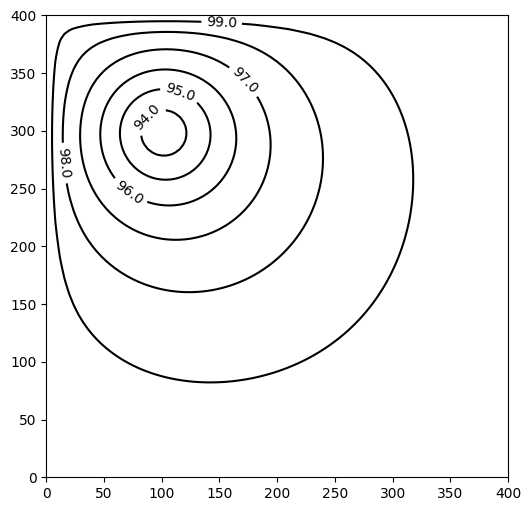

In [17]:
#построение графика слоя №1
fig = plt.figure(figsize=(6, 6)) # указывается размер графики в figsize
ax = fig.add_subplot(1, 1, 1, aspect="equal") #создается 3 оси
c = ax.contour(x, y, h[0], contour_intervals, colors="black") #к каждой оси привязывается свой параметр (указанный ранее)
plt.clabel(c, fmt="%2.1f")

<a list of 11 text.Text objects>

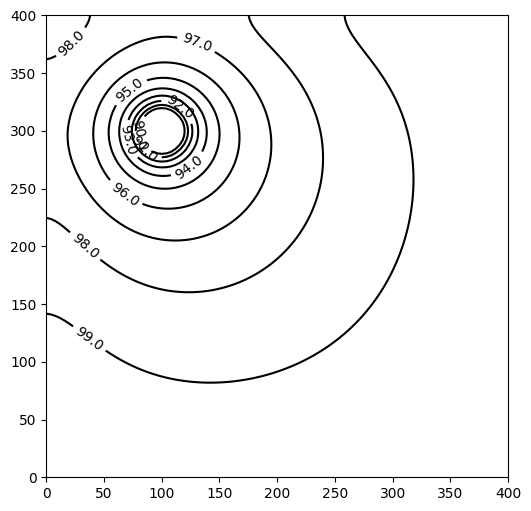

In [18]:
#построение графика слоя №10
x = y = np.linspace(0, L, N)# создаются переменные х, y. ссылается на 7 пункт
y = y[::-1]
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[-1], contour_intervals, colors="black")
plt.clabel(c, fmt="%1.1f")

<a list of 15 text.Text objects>

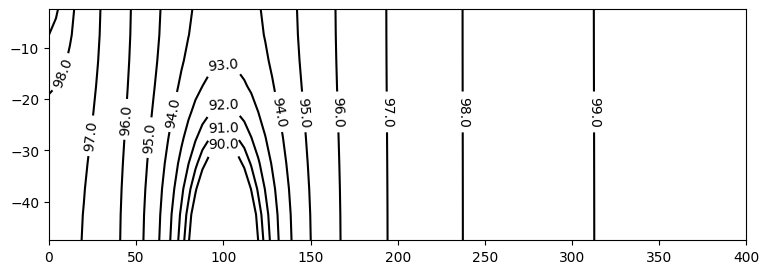

In [19]:
#построение разреза по строке 25
z = np.linspace(-H / Nlay / 2, -H + H / Nlay / 2, Nlay)#создание параметра, ссылка снова на 7 пункт
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1, aspect="auto")
c = ax.contour(x, z, h[:, int(N / 4), :], contour_intervals, colors="black")
plt.clabel(c, fmt="%1.1f")

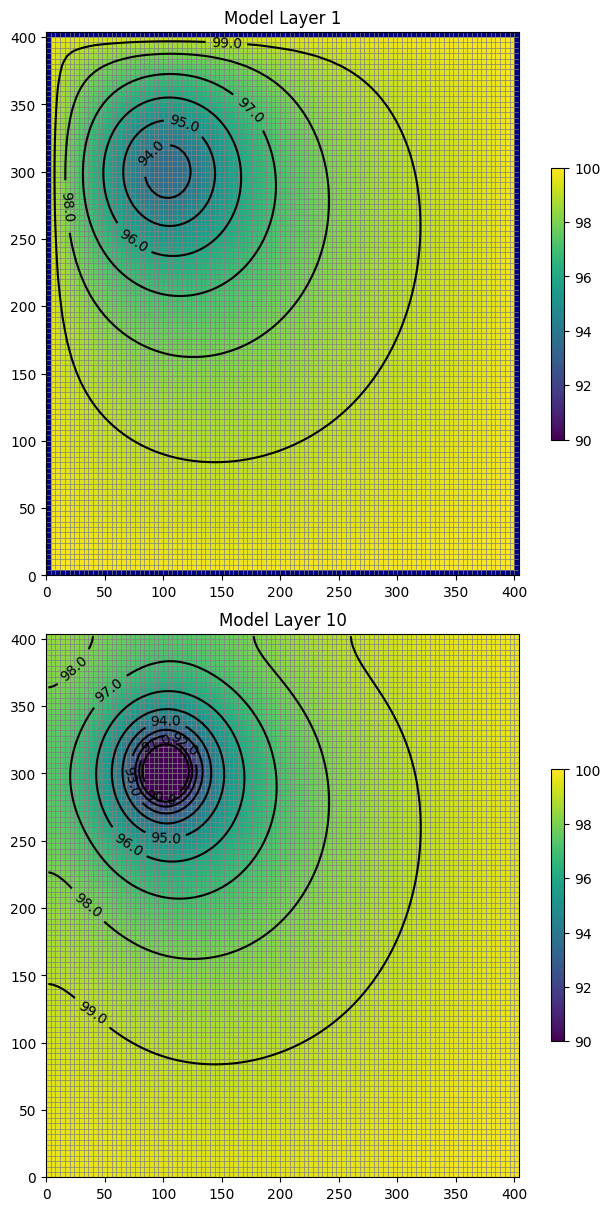

In [20]:
#использование FLOPY PlotMapViev() для модфлоу 6.
fig, axes = plt.subplots(2, 1, figsize=(6, 12), constrained_layout=True)
# first subplot
ax = axes[0]
ax.set_title("Model Layer 1")
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax)
pa = modelmap.plot_array(h, vmin=vmin, vmax=vmax)
quadmesh = modelmap.plot_bc("CHD")
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
contours = modelmap.contour_array(
    h,
    levels=contour_intervals,
    colors="black",
)
ax.clabel(contours, fmt="%2.1f")
cb = plt.colorbar(pa, shrink=0.5, ax=ax)
# second subplot
ax = axes[1]
ax.set_title(f"Model Layer {Nlay}")
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=Nlay - 1)
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
pa = modelmap.plot_array(h, vmin=vmin, vmax=vmax)
quadmesh = modelmap.plot_bc("CHD")
contours = modelmap.contour_array(
    h,
    levels=contour_intervals,
    colors="black",
)
ax.clabel(contours, fmt="%2.1f")
cb = plt.colorbar(pa, shrink=0.5, ax=ax)

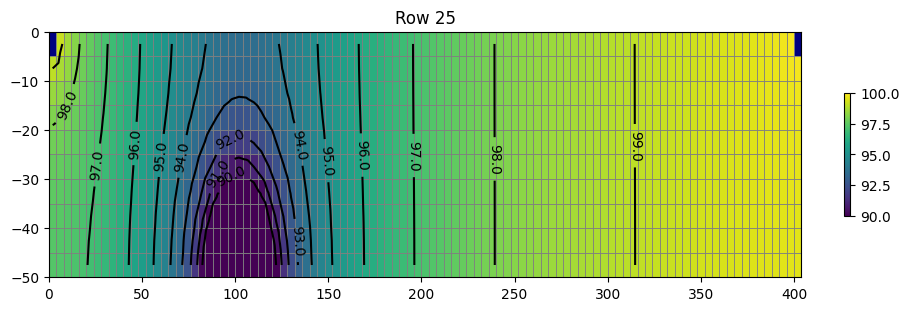

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3), constrained_layout=True)
# first subplot
ax.set_title("Row 25")
modelmap = flopy.plot.PlotCrossSection(
    model=gwf,
    ax=ax,
    line={"row": int(N / 4)},
)
pa = modelmap.plot_array(h, vmin=vmin, vmax=vmax)
quadmesh = modelmap.plot_bc("CHD")
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
contours = modelmap.contour_array(
    h,
    levels=contour_intervals,
    colors="black",
)
ax.clabel(contours, fmt="%2.1f")
cb = plt.colorbar(pa, shrink=0.5, ax=ax)

In [22]:
flowja = gwf.oc.output.budget().get_data(text="FLOW-JA-FACE", kstpkper=(0, 0))[
    0
]

In [23]:
grb_file = f"{name}.dis.grb"
residual = flopy.mf6.utils.get_residuals(flowja, grb_file=grb_file)

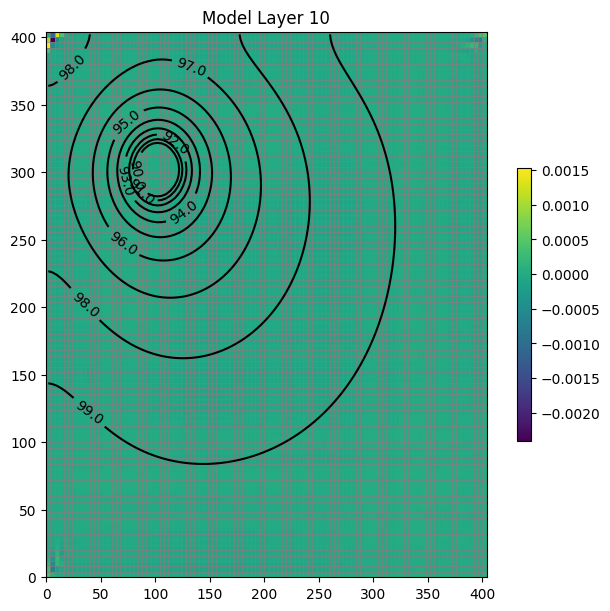

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
ax.set_title("Model Layer 10")
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=Nlay - 1)
pa = modelmap.plot_array(residual)
quadmesh = modelmap.plot_bc("CHD")
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
contours = modelmap.contour_array(
    h,
    levels=contour_intervals,
    colors="black",
)
ax.clabel(contours, fmt="%2.1f")
plt.colorbar(pa, shrink=0.5)